In [1]:
import numpy as np

from astropy.timeseries import LombScargle
import matplotlib.pyplot as plt
import lightkurve as lk 
import pandas as pd

/Users/neisner/opt/anaconda3/lib/python3.9/site-packages/lightkurve/config/__init__.py:119: UserWarning: The default Lightkurve cache directory, used by download(), etc., has been moved to /Users/neisner/.lightkurve/cache. Please move all the files in the legacy directory /Users/neisner/.lightkurve-cache to the new location and remove the legacy directory. Refer to https://docs.lightkurve.org/reference/config.html#default-cache-directory-migration for more information.
  warnings.warn(


In [2]:
times_gapped  = np.loadtxt('TIC55525572_yr3.txt').T
times_no_gaps = np.loadtxt('TIC55525572_yr3_nogaps.txt').T

step = 2./1440.

T0_list, gap_length = [], []

tlast = times_gapped[0]
for t in times_gapped[1:]:
    if t > tlast+step*1.1:
        T0_list.append(tlast)
        gap_length.append(t-tlast)
    tlast = t
    
    
# T0_list = #lists of the startign times of the gaps
# gap_length =  # list of the lengths of the gaps
times_masked = times_no_gaps
#signal_masked  = signal_no_gaps

for ii, T0 in enumerate(T0_list):
    
    mask = (times_masked > T0) & (times_masked < (T0 + gap_length[ii]))
    times_masked  = times_masked[~mask]
#   signal_masked = signal_masked[~mask]

print(len(times_no_gaps), len(times_masked))


# make fake flux data with a few modes
# stupid because writing the same code twice; use lists!
amps = [0.01, 0.000005, 0.00001, 0.000005]
omegas = [300., 400., 410., 420.]
phis = [0., 0.1, 0.2, 0.3]

flux_gapped = np.ones_like(times_gapped)
flux_no_gaps = np.ones_like(times_no_gaps)

for A, om, ph in zip(amps, omegas, phis):
    flux_gapped += A * np.cos(om * times_gapped + ph)
    flux_no_gaps += A * np.cos(om * times_no_gaps + ph)

flux_gapped += 1.e-4 * np.random.normal(size=len(flux_gapped))
flux_no_gaps += 1.e-4 * np.random.normal(size=len(flux_no_gaps))

from astropy.timeseries import LombScargle

deltaf = 0.5/(np.max(times_gapped) - np.min(times_gapped))
maxf = 0.5 / np.median(times_gapped[1:] - times_gapped[:-1]) # assumes data are ordered in time
fgrid = np.arange(deltaf, maxf, deltaf)

amp_wg = LombScargle(times_gapped, flux_gapped).power(fgrid)
amp_w = LombScargle(times_no_gaps, flux_no_gaps).power(fgrid)

nu_w = fgrid
nu_wg = fgrid

254476 226825


In [3]:
time = np.array(times_gapped)
flux = np.array(flux_gapped)
dflux = 1.e-5 * np.random.normal(size=len(times_gapped))

good = np.logical_and(np.isfinite(time), np.isfinite(flux), np.isfinite(dflux))

time = time[good] - np.median(time[good])
flux = flux[good] - np.median(flux[good])
dflux = dflux[good]

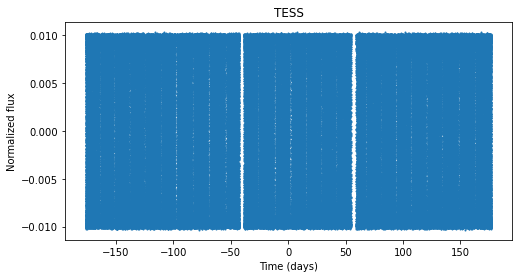

In [4]:
# plot data 

fig, ax = plt.subplots(figsize = (8,4))

plt.scatter(time, flux, s = 1)

plt.title("TESS")
plt.xlabel("Time (days)")
plt.ylabel("Normalized flux")
plt.show()

In [5]:
from astropy.timeseries import LombScargle

deltaf = 0.5/(np.max(times_gapped) - np.min(times_gapped))
maxf = 0.5 / np.median(times_gapped[1:] - times_gapped[:-1]) # assumes data are ordered in time
fgrid = np.arange(deltaf, maxf, deltaf)

amp_wg = LombScargle(times_gapped, flux_gapped).power(fgrid)
amp_w = LombScargle(times_no_gaps, flux_no_gaps).power(fgrid)

nu_w = fgrid
nu_wg = fgrid


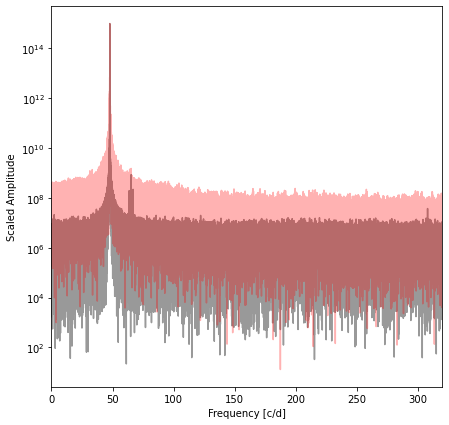

In [6]:
fig, ax = plt.subplots(1,1, figsize=(7,7))
ax.plot(nu_w, amp_w*1e15,'k',alpha=0.4)
# ax.plot(-1*nu_w, amp_w*1e15,'k',alpha=0.4)
ax.plot(nu_wg, amp_wg*1e15,'r',alpha=0.3)
# ax.plot(-1*nu_wg, amp_wg*1e15,'r',alpha=0.3)
ax.set_xlabel(r'Frequency [c/d]')
ax.set_ylabel(r'Scaled Amplitude')
#ax.set_ylim(0.0001,2.)
ax.set_xlim(0.,320.)
ax.set_yscale('log')
#fig.savefig('window_function.png')


In [7]:
# This set of functions does the traditional fitting Hogg loves
def _hogg_design_matrix(fs, ts):
    assert np.all(fs > 0.)
    N = len(ts)
    X = np.ones_like(ts)
    for f in fs:
        X = np.vstack([np.exp(-2.j * np.pi * f * ts), X, np.exp(2.j * np.pi * f * ts)])
    return X.T

def hogg_traditional_fit(ts, ys, fs):
    X = _hogg_design_matrix(fs, ts)
    Zs, _, _, _ = np.linalg.lstsq(X, ys, rcond=1e-9) # MAGIC
    return Zs, X

In [8]:
def WtLSP_init(time):
    fpeaks = np.array([])
    ppeaks = np.array([])
    deltaf = 0.5/(np.max(time) - np.min(time))
    maxf = 0.5 / np.median(time[1:] - time[:-1]) # assumes data are ordered in time
    fgrid = np.arange(deltaf, maxf, deltaf)
    
    return fpeaks, ppeaks, deltaf, fgrid

In [9]:
def parabola_peak(ys, plot= False):
    """
    ## Notes:
    - Assumes `ys` is shape `(3, )`
    - Assumes data are equally spaced!
    """
    y_minus, y_zero, y_plus = ys
    a0 = y_zero
    a1 = (y_plus - y_minus) / 2
    a2 = y_plus - (2. * y_zero) + y_minus
    x_max = -1. * a1 / a2
    y_max = a0 + a1 * x_max + 0.5 * a2 * x_max * x_max
    
    if plot: 
        print (a0, a1, a2)
        plt.scatter(np.arange(3) - 1, ys)
        xplot = np.linspace(-1.5,1.5,100)
        
        plt.plot(xplot,a0 + a1 * xplot + 0.5 * a2 * xplot**2, 'r-')
        plt.scatter(x_max, y_max)
        
        #plt.scatter(fgrid[maxi - 1: maxi + 2], pgrid[maxi - 1: maxi + 2])

    return x_max, y_max

In [10]:
def create_fs_horror(fpeaks, deltaf, Khalf=1):
    tiny = 1.e-9 # magic
    foo = np.concatenate([np.arange(f - Khalf * deltaf, f + (Khalf + 0.5) * deltaf, deltaf) for f in fpeaks])
    return foo[foo > tiny]

def WtLSP_step(time, flux, dflux, resid, fps, pps, deltaf, fgrid, i, maxiter, Khalf, flimit = 100000, ax=None):
    
    #print (time[0], resid[0], dflux[0])
    
    pgrid = LombScargle(time, resid, dflux).power(fgrid)
    
    print ("WtLSP_step(): sum of pgrid: {}".format(np.sum(pgrid)))

    # find the tallest peak 
    flimit_mask = [fgrid < flimit] # only up to a certain flimit
    maxi = np.argmax(pgrid[flimit_mask[0]])
    
    if maxi == 0:
        fpeaks = np.append(fps, fgrid[0])
        ppeaks = np.append(pps, pgrid[0])
    else: 
        dimensionless_shift, p = parabola_peak(pgrid[maxi - 1: maxi + 2])
        fpeaks = np.append(fps, fgrid[maxi] + dimensionless_shift * deltaf)
        ppeaks = np.append(pps, p)
    
    fs = create_fs_horror(fpeaks, deltaf, Khalf)
    Zs, XX = hogg_traditional_fit(time, flux, fs)
    resid = flux - (XX @ Zs).real

    if ax is not None: 
        # if True:                         # make all plots
        if (i == 0) or (i == maxiter - 1): # make only the first and last plot
            if (i == 0):
                factor = 5
            else:
                factor = 1
            
            WtLSP_plot(ax, fgrid, pgrid * factor, i)
        
    return resid, fpeaks, ppeaks

In [11]:
def WtLSP_plot(ax, fgrid, pgrid, i):
    ax.plot(fgrid / 0.0864, pgrid, label = str(i), alpha = 0.5) 

In [12]:
def WtLSP(time, flux, dflux, Khalf, maxiter=5):

    fpeaks, ppeaks, deltaf, fgrid = WtLSP_init(time)
        
    resid = flux.copy()
    
    fig, ax = plt.subplots(figsize = (10,7))
    
    for i in range(maxiter):
        
        resid, fpeaks, ppeaks = WtLSP_step(time, flux, dflux, resid, fpeaks, ppeaks,
                                           deltaf, fgrid, i, maxiter, Khalf, ax=ax)
        print(fpeaks/0.0864)
    
    #ax.loglog()
    ax.legend()
    plt.xlim(54,66)
    plt.ylim(0,0.0001)
    #ax.set_ylim(1.e-4 * np.max(ppeaks), 1.e1 * np.max(ppeaks))
    return resid, fpeaks, ppeaks, ax

WtLSP_step(): sum of pgrid: 104856.63789890199
[552.62554036]
WtLSP_step(): sum of pgrid: 116734.7877789758
[ 552.62554036 1915.04671574]


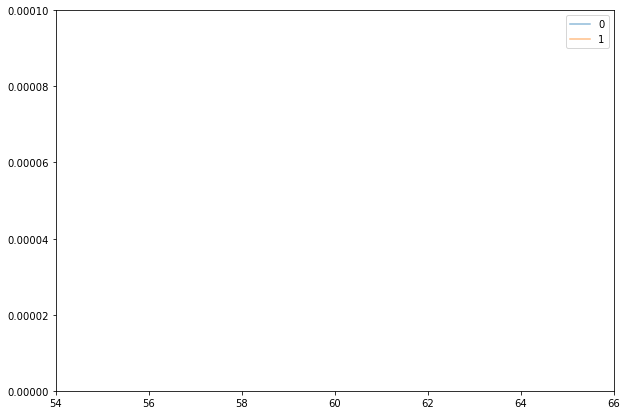

In [13]:
resid, fpeaks, ppeaks, ax = WtLSP(time, flux, dflux, Khalf = 1, maxiter=2)
ax.scatter(fpeaks / 0.0864, ppeaks, marker = 'x', color = 'k')

In [14]:

A2 = 0.002 # flux units
omega2 = 2. * np.pi * 1.e2 # radians per day
phi2 = 1.1 # radians

def inj_signal(time, A, freq, phi):
    omega = 2. * np.pi * freq
    return (A * np.cos(omega * time + phi))
    

flux2 = flux + inj_signal(time, 0.002, 0.2e1, 1.1) + inj_signal(time, 0.005, 0.1e1, 0.1)

#flux2 = flux + (A2 * np.cos(omega2 * time + phi2))

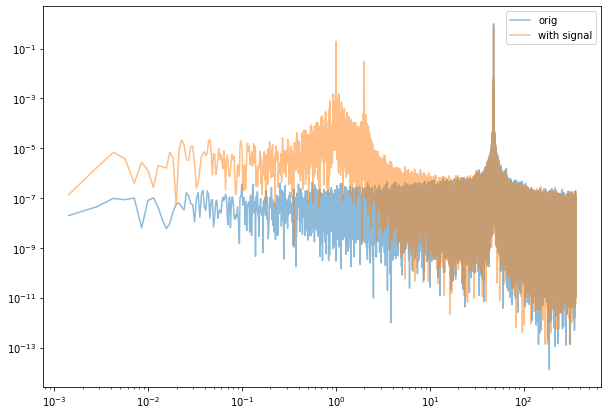

In [15]:
fig, ax = plt.subplots(figsize = (10,7))

deltaf = 0.5/(np.max(time) - np.min(time))
maxf = 0.5 / np.median(time[1:] - time[:-1]) # assumes data are ordered in time
fgrid = np.arange(deltaf, maxf, deltaf)
    
pgrid = LombScargle(time, flux).power(fgrid)
pgrid2 = LombScargle(time, flux2).power(fgrid)

plt.plot(fgrid, pgrid, label = 'orig', alpha = 0.5)
plt.plot(fgrid, pgrid2, label = 'with signal', alpha = 0.5)

plt.loglog()
plt.legend()

WtLSP_step(): sum of pgrid: 2.2391330027666942
[552.62187386]
WtLSP_step(): sum of pgrid: 2.2455598917865562
[552.62187386 755.24842462]
WtLSP_step(): sum of pgrid: 2.2455907676158495
[552.62187386 755.24842462 736.82768521]


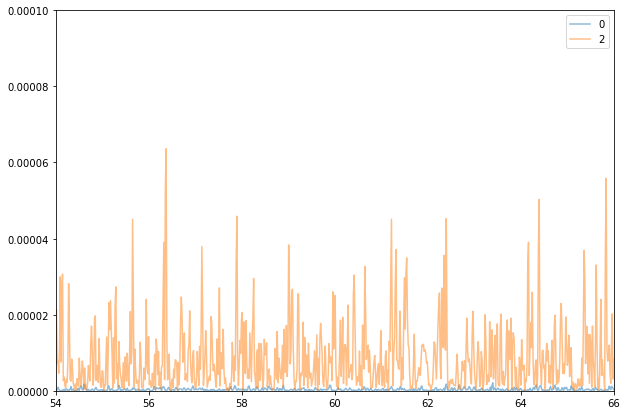

In [16]:
resid, fpeaks, ppeaks, ax = WtLSP(time, flux, 0.1 * np.ones_like(flux2), Khalf = 2, maxiter=3)
ax.scatter(fpeaks / 0.0864, ppeaks, marker = 'x', color = 'k')

In [17]:
def sine(x, amplitude, frequency, phase):
    return amplitude*np.sin(2.*np.pi*frequency*x + phase)

In [18]:
import scipy

times_gapped  = np.loadtxt('TIC55525572_yr3.txt').T
times = np.loadtxt('TIC55525572_yr3_nogaps.txt').T

amplitude = 2.
frequency = 1./0.02
phase = -0.4 * np.pi

print (frequency/0.0864)

flux_sine_       = sine(times, amplitude, frequency, phase)
flux_sine_gapped = sine(times_gapped,  amplitude, frequency, phase)

dflux_sine_gapped = 0.1 * np.ones_like(times_gapped)
flux_sine_gapped += dflux_sine_gapped * np.random.normal(size=len(times_gapped))

amp_gapped = LombScargle(times_gapped, flux_sine_gapped, dflux_sine_gapped).power(fgrid)
amp_ = LombScargle(times, flux_sine_).power(fgrid)

#amp_gapped = scipy.signal.lombscargle(times_gapped, flux_sine_gapped, fgrid)
#amp_ = scipy.signal.lombscargle(times, fgrid)



578.7037037037037


In [19]:
#fig, ax = plt.subpots()
#
#plt.plot(fgrid, amp_gapped)
#plt.plot(fgrid, amp_)

WtLSP_step(): sum of pgrid: 2.2392675027717734
[578.70443373]
WtLSP_step(): sum of pgrid: 2.2439735525613145
[578.70443373 578.72465595]


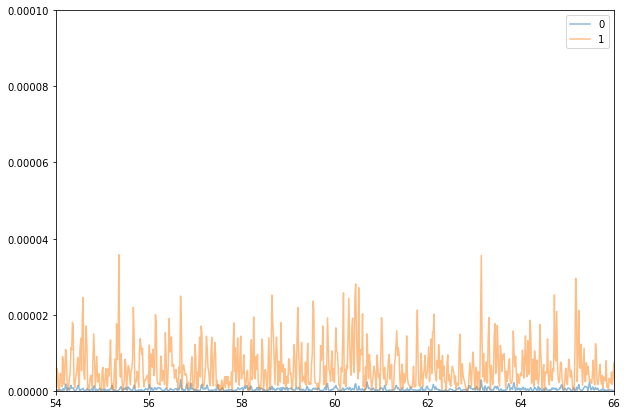

In [20]:
resid, fpeaks, ppeaks, ax = WtLSP(times_gapped, flux_sine_gapped, dflux_sine_gapped, Khalf = 0, maxiter=2)
ax.scatter(fpeaks / 0.0864, ppeaks, marker = 'x', color = 'k')

In [21]:
# make an animation that shows how the periodogram changes as the signal is increased. 

(2050.0, 2050.5)

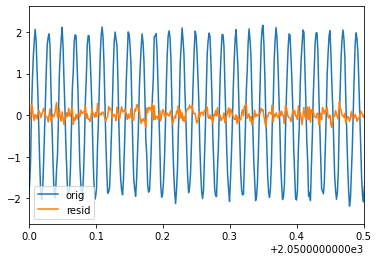

In [22]:
fig, ax = plt.subplots()

plt.plot(times_gapped, flux_sine_gapped, label = 'orig')
plt.plot(times_gapped, resid, label = 'resid')
plt.legend()
plt.xlim(2050,2050.5)